This notebook uses uses an Autoencoders to pretrain a model on the [CIFAR10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).


I explore how we can use Autoencoders to pretrain a model and then reuse the lower layers of the autoencoder (i.e. the encoder) and train it on a smaller sample within the dataset.

This lead to increase performance when compared to the baseline model that had not been pretrained. 

# Load Data

In [1]:
import sys 
sys.version_info > (3, 5)

import numpy as np
import tensorflow as tf
assert tf.__version__ > "2.0"
from tensorflow import keras
import matplotlib.pyplot as plt

In [2]:
[X_train_full, y_train_full], [X_test, y_test] = keras.datasets.cifar10.load_data()
X_train_full = X_train_full / 255. #scale data so it is between 0 to 1
X_test = X_test / 255.

# Explore and Prepare Data

We already know a lot about the famous CIFAR10 dataset, but below is a quick summary on the shape and the sort of images we expect.

In [3]:
X_train_full.shape

(50000, 32, 32, 3)

In [4]:
# split into validation and train datasets 
X_train, y_train = X_train_full[10000:], y_train_full[10000:]
X_valid, y_valid = X_train_full[:10000], y_train_full[:10000]

In [5]:
X_train.shape

(40000, 32, 32, 3)

In [6]:
np.unique(y_train) # there are 10 classes

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [7]:
# lets get the class names as specified on the website.
class_names = [
               'airplane', 'automobile', 'bird',
               'cat', 'deer', 'dog', 'frog', 
               'horse', 'ship', 'truck'
               ]

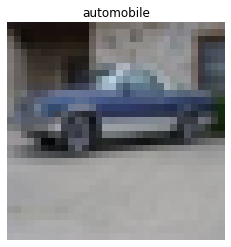

In [8]:
def plot_cifar10_data(image=X_train[0], label_index=y_train[0]):
  """
  Function to plot CIFAR10 data.
  """
  plt.title(class_names[label_index.item()])
  plt.imshow(image)
  plt.axis('off')

plot_cifar10_data()

In [9]:
def plot_multiple_images(X_train=X_train, y_train=y_train, n_cols=None, n_rows=None):
  """
  Function that plots multiple CIFAR10 data.
  """
  plt.figure(figsize=(n_cols*2, n_rows*2))
  for index in range(n_cols * n_rows):
    plt.subplot(n_rows, n_cols, index + 1)
    plot_cifar10_data(image=X_train[index], label_index=y_train[index])

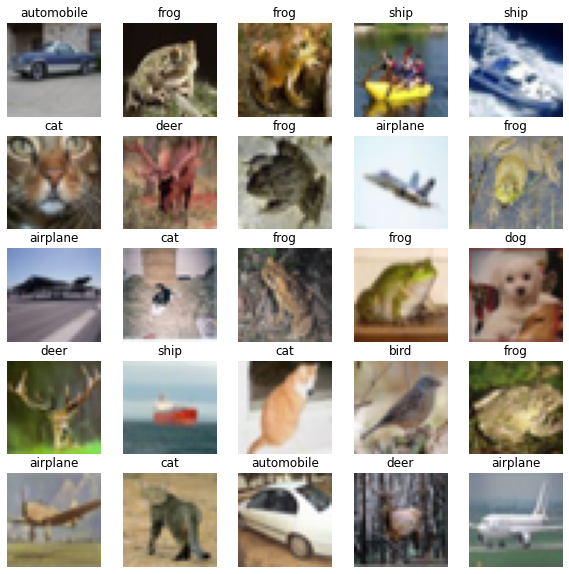

In [10]:
plot_multiple_images(X_train=X_train, y_train=y_train, n_cols=5, n_rows=5)
plt.show()

Now that we have scaled the data, lets build a few Autoencoder models.

--- 

# Train Models

In [11]:
X_valid.shape

(10000, 32, 32, 3)

In [12]:
# set the seed so model is reproducible
tf.random.set_seed(42)
np.random.seed(42) 

Instead of using the accuracy or MSE as the metric, lets create function that uses either has the pixel on or off.

In [13]:
def rounded_accuracy (y_true, y_pred):
  """
  Metric to use when comparing on and off pixels.
  """
  return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

## Denoiser Autoencoder

In [14]:
denoise_encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[32, 32, 3]),
  keras.layers.GaussianNoise(0.5),
  keras.layers.Dense(units=200, activation='selu'),
  keras.layers.Dense(units=400, activation='selu'),
  keras.layers.Dense(units=32*32, activation='selu'),
  keras.layers.Dense(512, activation='selu')
])

denoise_decoder = keras.models.Sequential([
  keras.layers.Dense(units=32*32, activation='selu', input_shape=[512]),
  keras.layers.Dense(units=400, activation='selu'),
  keras.layers.Dense(units=200, activation='selu'),
  keras.layers.Dense(32 * 32 * 3, activation='sigmoid'),
  keras.layers.Reshape([32, 32, 3])
])

denoise_ae = keras.models.Sequential([denoise_encoder, denoise_decoder])

denoise_ae.compile(loss='binary_crossentropy', optimizer='nadam',
                   metrics=[rounded_accuracy])

In [15]:
denoise_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1250/1250 [==============================] - 98s 77ms/step - loss: 0.6407 - rounded_accuracy: 0.7248 - val_loss: 0.6158 - val_rounded_accuracy: 0.7820
Epoch 2/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.6140 - rounded_accuracy: 0.7862 - val_loss: 0.6098 - val_rounded_accuracy: 0.7917
Epoch 3/10
1250/1250 [==============================] - 95s 76ms/step - loss: 0.6100 - rounded_accuracy: 0.7948 - val_loss: 0.6038 - val_rounded_accuracy: 0.8058
Epoch 4/10
1250/1250 [==============================] - 96s 77ms/step - loss: 0.6068 - rounded_accuracy: 0.8014 - val_loss: 0.6023 - val_rounded_accuracy: 0.8102
Epoch 5/10
1250/1250 [==============================] - 96s 77ms/step - loss: 0.6052 - rounded_accuracy: 0.8050 - val_loss: 0.6005 - val_rounded_accuracy: 0.8157
Epoch 6/10
1250/1250 [==============================] - 96s 77ms/step - loss: 0.6040 - rounded_accuracy: 0.8081 - val_loss: 0.6004 - val_rounded_accuracy: 0.8124
Epoch 7/10
1250/1250 [======

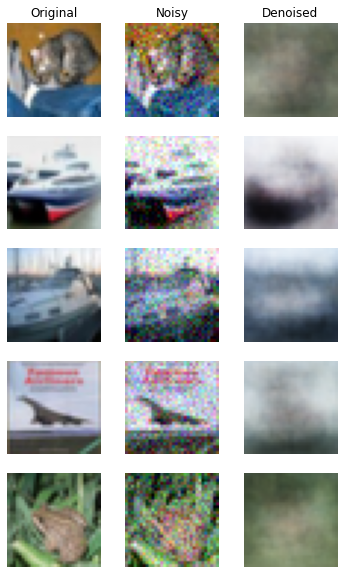

In [16]:
n_images = 5
new_images = X_test[:n_images]
new_images_noisy = new_images + np.random.randn(n_images, 32, 32, 3) * 0.1
new_images_denoised = denoise_ae.predict(new_images_noisy)

plt.figure(figsize=(6, n_images * 2))
for index in range(n_images):
    plt.subplot(n_images, 3, index * 3 + 1)
    plt.imshow(new_images[index])
    plt.axis('off')
    if index == 0:
        plt.title("Original")
    plt.subplot(n_images, 3, index * 3 + 2)
    plt.imshow(np.clip(new_images_noisy[index], 0., 1.))
    plt.axis('off')
    if index == 0:
        plt.title("Noisy")
    plt.subplot(n_images, 3, index * 3 + 3)
    plt.imshow(new_images_denoised[index])
    plt.axis('off')
    if index == 0:
        plt.title("Denoised")
plt.show()

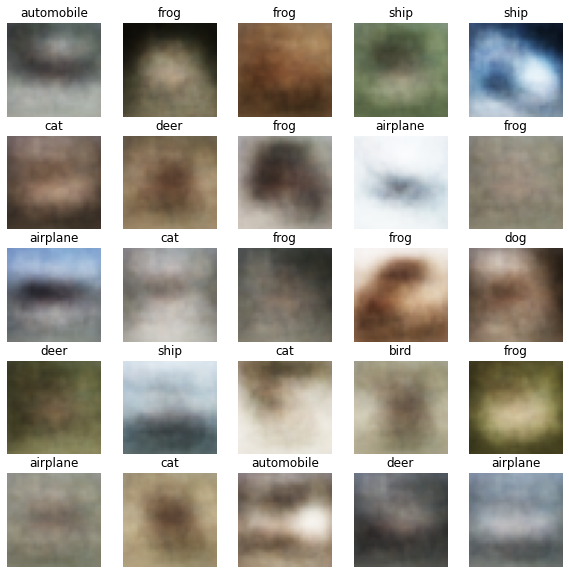

In [17]:
plot_multiple_images(X_train=denoise_ae.predict(X_train), y_train=y_train, n_cols=5, n_rows=5)
plt.show()

Lets now use the encoder and see how that performs against a smaller dataset.

In [18]:
X_small_dataset, y_small_dataset = X_valid[:500], y_valid[:500]

pretrained_denoiser = keras.models.Sequential([
  denoise_encoder,
  keras.layers.Dense(10, activation='softmax')
])

pretrained_denoiser.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
                   metrics=['accuracy'])

pretrained_denoiser.fit(X_small_dataset, y_small_dataset, epochs=10)

Epoch 1/10
16/16 [==============================] - 2s 37ms/step - loss: 7.0751 - accuracy: 0.1460
Epoch 2/10
16/16 [==============================] - 1s 37ms/step - loss: 2.6217 - accuracy: 0.2380
Epoch 3/10
16/16 [==============================] - 1s 37ms/step - loss: 2.2355 - accuracy: 0.2900
Epoch 4/10
16/16 [==============================] - 1s 36ms/step - loss: 1.9521 - accuracy: 0.3200
Epoch 5/10
16/16 [==============================] - 1s 36ms/step - loss: 1.8994 - accuracy: 0.3300
Epoch 6/10
16/16 [==============================] - 1s 36ms/step - loss: 1.8729 - accuracy: 0.3780
Epoch 7/10
16/16 [==============================] - 1s 36ms/step - loss: 1.6424 - accuracy: 0.4220
Epoch 8/10
16/16 [==============================] - 1s 36ms/step - loss: 1.4747 - accuracy: 0.4540
Epoch 9/10
16/16 [==============================] - 1s 37ms/step - loss: 1.4403 - accuracy: 0.4740
Epoch 10/10
16/16 [==============================] - 1s 37ms/step - loss: 1.2288 - accuracy: 0.5540


In [19]:
baseline_encoder = keras.models.Sequential([
  keras.layers.Flatten(input_shape=[32, 32, 3]),
  keras.layers.GaussianNoise(0.5),
  keras.layers.Dense(units=200, activation='selu'),
  keras.layers.Dense(units=400, activation='selu'),
  keras.layers.Dense(units=32*32, activation='selu'),
  keras.layers.Dense(512, activation='selu'),
  keras.layers.Dense(10, activation='softmax')
])

baseline_encoder.compile(loss='sparse_categorical_crossentropy', optimizer='nadam',
                   metrics=['accuracy'])

baseline_encoder.fit(X_small_dataset, y_small_dataset, epochs=10)

Epoch 1/10
16/16 [==============================] - 2s 35ms/step - loss: 11.7984 - accuracy: 0.0960
Epoch 2/10
16/16 [==============================] - 1s 37ms/step - loss: 5.9560 - accuracy: 0.1180
Epoch 3/10
16/16 [==============================] - 1s 37ms/step - loss: 3.0293 - accuracy: 0.1340
Epoch 4/10
16/16 [==============================] - 1s 36ms/step - loss: 2.5471 - accuracy: 0.1660
Epoch 5/10
16/16 [==============================] - 1s 36ms/step - loss: 2.5301 - accuracy: 0.1620
Epoch 6/10
16/16 [==============================] - 1s 35ms/step - loss: 2.4069 - accuracy: 0.1840
Epoch 7/10
16/16 [==============================] - 1s 36ms/step - loss: 2.5484 - accuracy: 0.1760
Epoch 8/10
16/16 [==============================] - 1s 35ms/step - loss: 2.2404 - accuracy: 0.1960
Epoch 9/10
16/16 [==============================] - 1s 36ms/step - loss: 2.1475 - accuracy: 0.2200
Epoch 10/10
16/16 [==============================] - 1s 35ms/step - loss: 2.1418 - accuracy: 0.2700


# Conclusion

Although the models were not great, the point of the exercise was to show that you can pretrain a model by using an Autoencoder. The accuracy for the pretrained model was greater than the baseline model that was not pretrained.

This shows that using an autoencoder to pretrain a model when you have a small labelled dataset work well in practice! In the example above we only used 500 labelled instances to train the model! - Although a deep model with Convolutional layers will produce a far superior model.
